In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from lattice_hamiltonians import *
from sympy import S, symbols, printing

from compilers import * 
from utils import *

import json

In [2]:
heisen = (heisenberg_hamiltonian(7, b_field=5, rng_seed=1, b_rand=False))
#heisen = exp_loc_graph_hamiltonian(7, 1, 1)

sim = CompositeSim(heisen, nb=1, inner_order=1, state_rand=True, exact_qd=True, use_density_matrices=True, imag_time=False)
partition_sim(sim, "trotter")

tstart = 0.005
tfinal = 2.5
tsteps = 300
times = np.geomspace(tstart, tfinal, tsteps)

#print(multi_infidelity_sample(sim, 1, exact_time_evolution_density(sim.unparsed_hamiltonian, 1, sim.initial_state), 40, 20))
epsilon_data=[]
for t in times:
    #density matrices
    epsilon_data.append(sim_trace_distance(sim, time=t, iterations=6, nb=1))
    #epsilon_data.append(infidelity(sim.simulate(t, iterations=15), exact_imaginary_channel(poli, t, sim.initial_state)))

    #imaginary time class
    #epsilon_data.append(i_sim.trace_dist(t, samples=1))

    #for vectors
    #exact_state = linalg.expm(-1 * sum(poli) * t) @ sim.initial_state
    #epsilon_data.append(infidelity(sim.simulate(t, iterations=1), exact_state / np.linalg.norm(exact_state, ord=2)))
#print(epsilon_data)
print('the trace is:')
print(np.trace(sim.final_state))


TypeError: array() takes from 1 to 2 positional arguments but 3 were given

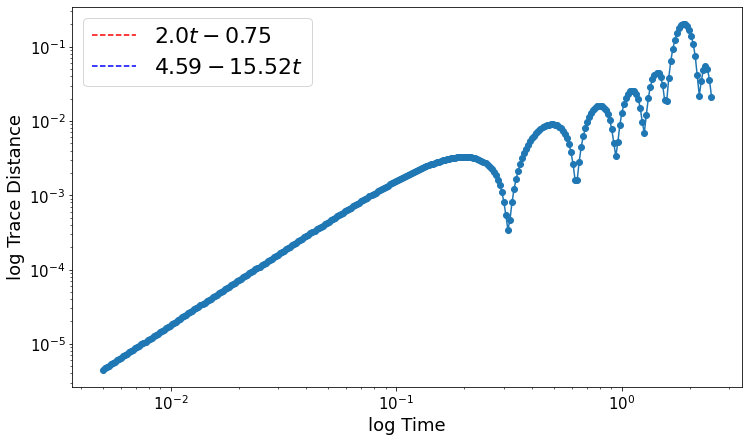

In [ ]:
data = np.log10(epsilon_data)
log_times = np.log10(times)
plt.figure(figsize = (12, 7))
plt.loglog(times, epsilon_data, 'o-') 
plt.xlabel('log Time', size = 18)
plt.ylabel('log Trace Distance', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

start_fit_points= 1 #declare the starting point to fit in the data
end_fit_points = 5

p = np.polyfit(log_times[start_fit_points: end_fit_points], data[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)
plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize= 22)

data = np.log10(epsilon_data)
start_fit_points1= -3 #declare the starting point to fit in the data
end_fit_points1 = -1
p1 = np.polyfit(log_times[start_fit_points1: end_fit_points1], data[start_fit_points1: end_fit_points1], 1)
f1 = np.poly1d(p1)

t_new1 = np.linspace(log_times[start_fit_points1], log_times[end_fit_points1], 50)
y_new1 = f1(t_new1)

data = symbols("t")
poly1 = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p1[::-1]))
eq_latex1 = printing.latex(poly1)

plt.plot(t_new1, y_new1, 'b--', label="${}$".format(eq_latex1))
plt.legend(fontsize= 22)
plt.show()

### Cost Analysis

In [5]:
heisenberg = exp_distr_heisenberg_hamiltonian(length = 7, b_field = 5, rng_seed=1, b_rand=False)
print(heisenberg.shape)
normed_ham = normalize_hamiltonian(heisenberg)

trotter = CompositeSim(normed_ham, inner_order=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=False) 
qdrift = CompositeSim(normed_ham, inner_order=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=False) 
chop = CompositeSim(normed_ham, inner_order=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=False)
#chop1_outer2 = CompositeSim(normed_ham, inner_order=1, outer_order=2, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=False)

partition_sim(trotter, 'trotter')
partition_sim(qdrift, "qdrift")

partition_sim(chop, "chop", chop_threshold = 0.75)
print(chop.trotter_norms, chop.qdrift_norms)
print(len(chop.trotter_norms), len(chop.qdrift_norms))

t_i = 0.005
t_f= 2.5
t_steps = 15
time = np.geomspace(t_i, t_f, t_steps)
epsilon=0.0001

print(time)
print(trace_distance(trotter.simulate(time = 1.02889928, iterations=4), 
    exact_time_evolution_density(normed_ham, time=1.02889928, initial_rho=trotter.initial_state)))

(25, 128, 128)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.01079211674518371, 0.025482505060266083, 2.2876271728617186e-06, 0.00720025509707838, 0.003174191903893478, 0.0019376774330746695, 0.00412229268164161, 0.008479529636141498, 0.010109050834214971, 0.015479195497215147, 0.010866787412364902, 0.02311759419418845, 0.004574488150536607, 0.04209394582415611, 0.0005553924953684671, 0.022201606529932652, 0.010801820928888588, 0.016360146278060757]
7 18
[0.005      0.00779388 0.01214891 0.01893742 0.02951918 0.04601377
 0.07172514 0.1118034  0.1742764  0.27165778 0.4234535  0.66006893
 1.02889928 1.603823   2.5       ]
0.004964384104083068


In [6]:
#CompSim_results = dict()
qdrift_results = dict()
trotter_results = dict()
chop_results = dict()

#local_partition(local_trot, "trotter")
trot_terms = dict()
qd_terms = dict()
nb_vals = dict()

for t in time:
    #optimal chop code
    #partition_sim(sim, "exact_optimal_chop", time = t, epsilon=epsilon)
    #chop_results[t] = int(sim.gate_count)
    #nb_vals[t] = sim.nb

    #std chop
    chop_results[t] = int(exact_cost(chop, time=t, nb=4, epsilon=epsilon))

    #trot_terms[t] = len(chop.trotter_norms)
    #qd_terms[t] = len(sim.qdrift_norms)

    trotter_results[t] = int(exact_cost(trotter, time=t, nb=1, epsilon=epsilon))

[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold


In [7]:
qd_times = time
for t in qd_times:
    qd_terms[t] = int(exact_cost(qdrift, time=t, nb=1, epsilon=epsilon))
    print(t)

0.005
0.00779387751027389
0.012148905329030643
0.01893741600367571
0.02951918013874983
0.04601377484102521
0.07172514497925464
0.11180339887498947


KeyboardInterrupt: 

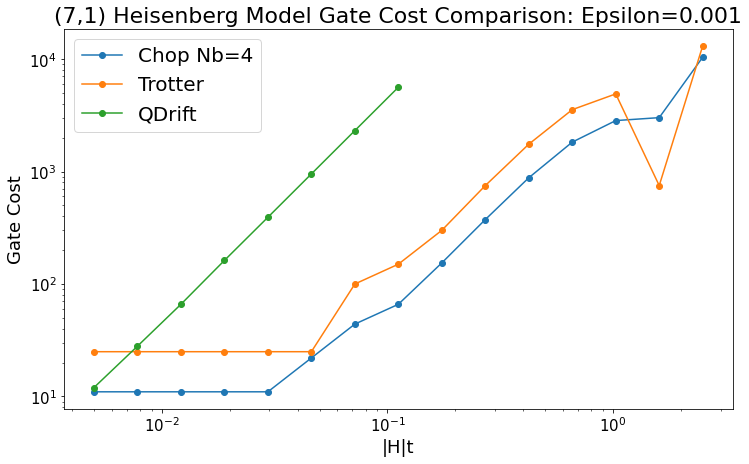

[25, 25, 25, 25, 25, 25, 100, 150, 300, 750, 1750, 3550, 4900, 750, 13100]


In [8]:
#plotting
plt.figure(figsize = (12, 7))
plt.title("(7,1) Heisenberg Model Gate Cost Comparison: Epsilon=0.001", size =22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("|H|t", size =18)
plt.ylabel("Gate Cost", size =18)
plt.loglog(time, list(chop_results.values()), "o-", label="Chop Nb=4")
#plt.loglog(time, list(local_trot_results.values()), "o-", label="Local Trotter")
plt.loglog(time, list(trotter_results.values()), "o-",label="Trotter")
plt.loglog(qd_times[:8], list(qd_terms.values()),"o-", label="QDrift")
plt.legend(fontsize = 20)
plt.show()

print(list(trotter_results.values()))

In [ ]:
print(list(chop_results.values()))
print(np.trace(trotter.final_state))

In [ ]:
emplist = []
for i in range(0, 20):
    emplist.append(i)
print(emplist[-4:])

[16, 17, 18, 19]


### Dynamics

In [3]:
dim = 6
#ising = normalize_hamiltonian(ising_model(dim=dim, b_field=1.5))
ising = ising_model(dim=dim, b_field=0.1)
cooler = CompositeSim(ising, inner_order=1, nb=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=True, rng_seed=1) 
partition_sim(cooler, "trotter")
print(cooler.initial_state)
 
beta = np.linspace(0.00001, 1.5, 100)
populations = []
energies = []
spins = []
amplitudes = np.zeros((2**dim, len(beta)))
x_measurements = []

for b in range(len(beta)):
    state_t = cooler.simulate(time=beta[b], iterations=100)
    if cooler.use_density_matrices == True:
        #populations.append(np.real(np.diag(state_t))
        energies.append(np.real(np.trace(sum(ising) @ state_t)))
        local_spin = []
        local_x = []
        for j in range(dim):
            local_spin.append(np.real(np.trace(state_t @ initialize_operator(Z, j, dim))))
            local_x.append(np.real(np.trace(state_t @ initialize_operator(X, j, dim))))
        spins.append(local_spin)
        x_measurements.append(local_x)
    else:
        energies.append(np.real((state_t.T.conj() @ sum(ising) @ state_t).flat[0]))
        amplitudes[:, b] =  np.real(np.abs(state_t.flat[0])**2)
amplitudes = np.transpose(amplitudes)

[[ 0.02692756+0.j         -0.00964571-0.00164814j -0.00285558-0.01961837j
  ...  0.02469851-0.01306447j  0.01523956-0.02239909j
  -0.00298631-0.00650151j]
 [-0.00964571+0.00164814j  0.00355606+0.j          0.00222366+0.00685271j
  ... -0.00804761+0.00619152j -0.00408799+0.00895632j
   0.00146766+0.00214612j]
 [-0.00285558+0.01961837j  0.00222366-0.00685271j  0.01459601+0.j
  ...  0.00689907+0.01937982j  0.014703  +0.0134783j
   0.00505344-0.00148625j]
 ...
 [ 0.02469851+0.01306447j -0.00804761-0.00619152j  0.00689907-0.01937982j
  ...  0.02899248+0.j          0.02484542-0.01315111j
   0.00041523-0.00741219j]
 [ 0.01523956+0.02239909j -0.00408799-0.00895632j  0.014703  -0.0134783j
  ...  0.02484542+0.01315111j  0.02725696+0.j
   0.00371804-0.00616361j]
 [-0.00298631+0.00650151j  0.00146766-0.00214612j  0.00505344+0.00148625j
  ...  0.00041523+0.00741219j  0.00371804+0.00616361j
   0.00190094+0.j        ]]


(array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

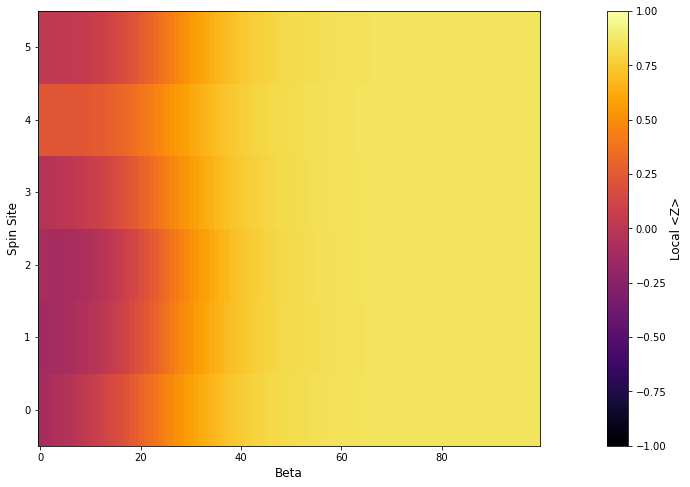

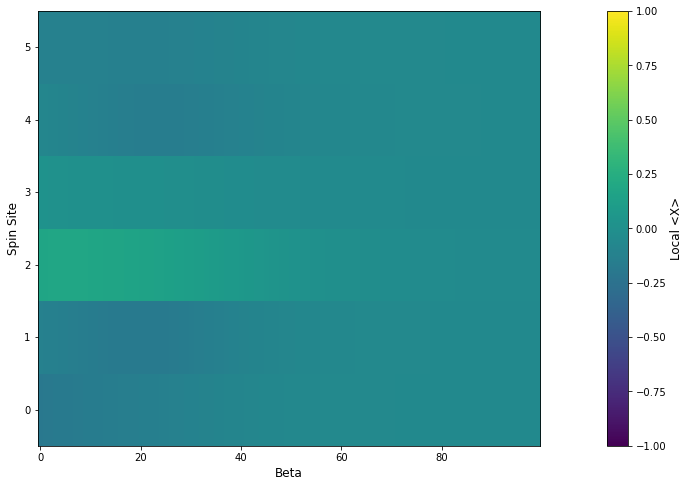

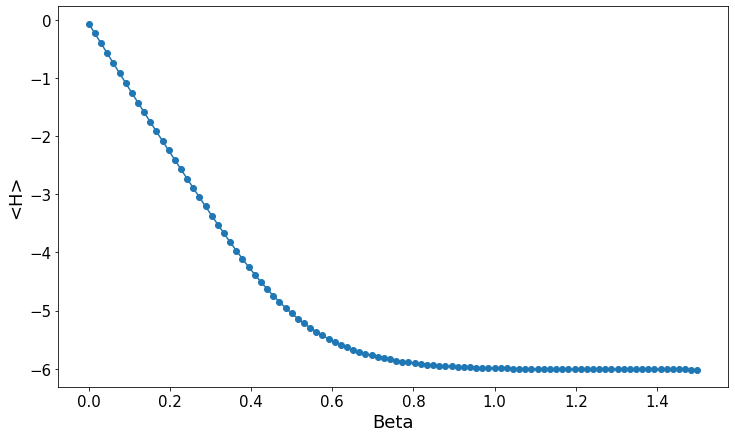

In [7]:
plt.figure(figsize = (12,8))
#plt.ylim(-60,60) #limits the range the plot shows
plt.xlabel('Beta', size = 12)
plt.ylabel('Spin Site', size = 12)
plt.imshow(np.transpose(spins), origin = 'lower', aspect = 'auto', 
           cmap = 'inferno', vmax=1, vmin=-1, interpolation = 'none') 
# vmax alters the sensitivity of the colour plot, so increase for large particle numbers
cbar = plt.colorbar(pad = 0.1) #pad chooses the distance of the colour bar from the plot
cbar.set_label('Local <Z>',size=12) 

plt.figure(figsize = (12,8))
#plt.ylim(-60,60) #limits the range the plot shows
plt.xlabel('Beta', size = 12)
plt.ylabel('Spin Site', size = 12)
plt.imshow(np.transpose(x_measurements), origin = 'lower', aspect = 'auto', 
             vmax=1, vmin=-1, interpolation = 'none') 
# vmax alters the sensitivity of the colour plot, so increase for large particle numbers
cbar = plt.colorbar(pad = 0.1) #pad chooses the distance of the colour bar from the plot
cbar.set_label('Local <X>',size=12)

plt.figure(figsize = (12, 7))
plt.plot(beta, energies, 'o-') 
plt.xlabel('Beta', size = 18)
plt.ylabel('<H>', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

In [ ]:
def mu(temp, vol):
    return (-8/27 * temp * np.log(3* vol -1) - 2/3 * 1/vol + temp * 8/27 * 1/(3*vol -1))

def pressure(temp, vol):
    return (8 * temp / (3*vol -1) - 3/ vol**2)  

def ionizing_frac(t, f_i):
    return (1/f_i * np.exp(-157971/ t) * 1/0.2436 * (8.457**26 / t)**(3/2))**(1/2)

In [ ]:
temp = 0.9
volumes = np.linspace(0.576, 4.909, 1000)
pressures = []
potential = []
for i in volumes:
    pressures.append(pressure(temp=temp, vol=i))
    potential.append(mu(temp=temp, vol=i))
#print(pressures)

temps = np.linspace(0, 6000, 1000)
frac = []
for j in temps:
    frac.append(ionizing_frac(j,10**(-9)))


/opt/anaconda3/envs/compsim/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/opt/anaconda3/envs/compsim/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


(array([-5.0e+13,  0.0e+00,  5.0e+13,  1.0e+14,  1.5e+14,  2.0e+14,
         2.5e+14]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

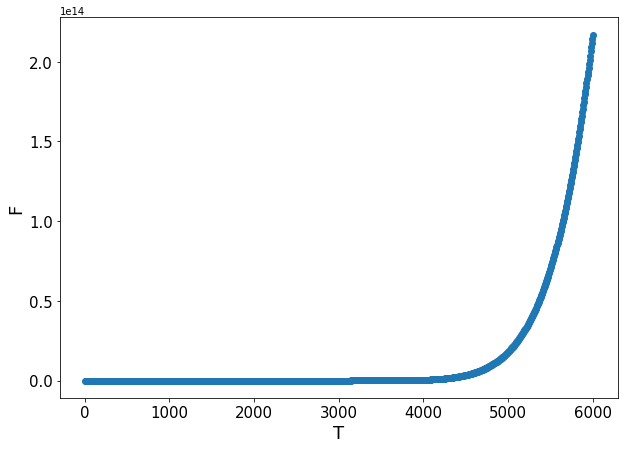

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(temps, frac, 'o-') 
plt.xlabel('T', size = 18)
plt.ylabel('F', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

(array([0., 1., 2., 3., 4., 5., 6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

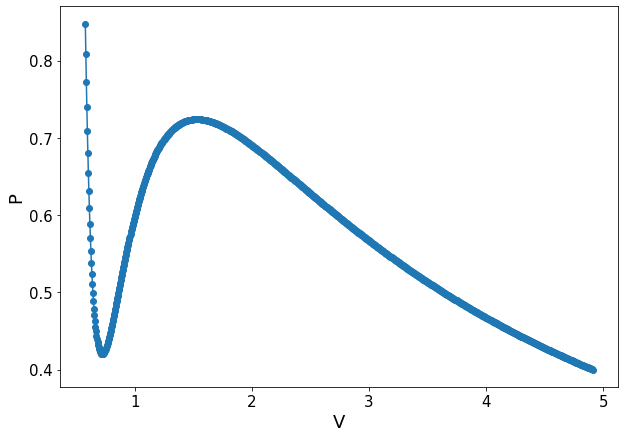

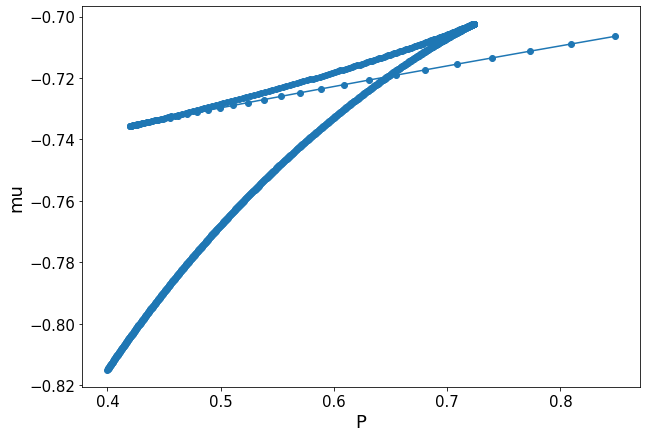

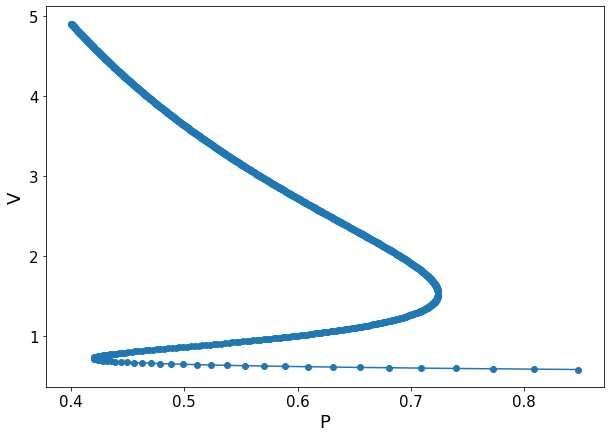

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(volumes, pressures, 'o-') 
plt.xlabel('V', size = 18)
plt.ylabel('P', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

plt.figure(figsize = (10, 7))
plt.plot(pressures, potential, 'o-') 
plt.xlabel('P', size = 18)
plt.ylabel('mu', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

plt.figure(figsize = (10, 7))
plt.plot(pressures, volumes, 'o-') 
plt.xlabel('P', size = 18)
plt.ylabel('V', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)